This notebook will be for data cleaning

Problem statement:
We are trying to optimize the WTWY signature-gathering team's placement for raising awareness of upcoming gala in June 2019. 

The end goals:
1. rank stations by foot traffic
2. plot 5 top stations by total traffic - hourly, daily, weekly
3. analyze demographics for top 5 stations - gender, income, industry
4. create scorecard with weighed combination of factors for each station

In [1]:
import pandas as pd

In [2]:
def get_data(week_nums):
    url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt"
    dfs = []
    for week_num in week_nums:
        file_url = url.format(week_num)
        dfs.append(pd.read_csv(file_url))
    return pd.concat(dfs,ignore_index=True)
        
week_nums = [190504,190511,190518,190525]
mta_df = get_data(week_nums)

In [3]:
# fixing EXITS label
mta_df.rename(columns={"EXITS                                                               ":'EXITS'},inplace=True)

In [5]:
# converting to datetime
mta_df["DATE_TIME"] = pd.to_datetime(mta_df.DATE + " " + mta_df.TIME, 
                                            format="%m/%d/%Y %H:%M:%S")

In [6]:
# dropping duplicates
mta_df.sort_values(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], 
                          inplace=True, ascending=False)

mta_df.drop_duplicates(subset=["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], inplace=True)

In [7]:
# creating daily df
mta_daily = (mta_df
                        .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE"],as_index=False)
                        ['ENTRIES','EXITS'].first())

<ipython-input-7-277383eb6d8a>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  mta_daily = (mta_df


In [8]:
# creating previous entries, previous exits, previous date
mta_daily[["PREV_DATE", "PREV_ENTRIES","PREV_EXITS"]] = (mta_daily
                                                       .groupby(["C/A", "UNIT", "SCP", "STATION"])["DATE", "ENTRIES",'EXITS']
                                                       .apply(lambda grp: grp.shift(1)))

mta_df[["PREV_DATE", "PREV_ENTRIES","PREV_EXITS"]] = (mta_df
                                                       .groupby(["C/A", "UNIT", "SCP", "STATION"])["DATE", "ENTRIES",'EXITS']
                                                       .apply(lambda grp: grp.shift(1)))

<ipython-input-8-cbbfde3ea405>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  mta_daily[["PREV_DATE", "PREV_ENTRIES","PREV_EXITS"]] = (mta_daily
<ipython-input-8-cbbfde3ea405>:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  mta_df[["PREV_DATE", "PREV_ENTRIES","PREV_EXITS"]] = (mta_df


In [9]:
# dropping NAs in the new columns
mta_daily.dropna(subset=["PREV_DATE"], axis=0, inplace=True)
mta_df.dropna(subset=["PREV_DATE"], axis=0, inplace=True)

In [10]:
# calculating real daily entries and exits
def get_real_entries(row, max_counter):
    counter = row["ENTRIES"] - row["PREV_ENTRIES"]
    if counter < 0:
        # Maybe counter is reversed?
        counter = -counter
    if counter > max_counter:
        # Maybe counter was reset to 0? 
        print(row["ENTRIES"], row["PREV_ENTRIES"])
        counter = min(row["ENTRIES"], row["PREV_ENTRIES"])
    if counter > max_counter:
        # Check it again to make sure we're not still giving a counter that's too big
        return 0
    return counter

def get_real_exits(row, max_counter):
    counter = row["EXITS"] - row["PREV_EXITS"]
    if counter < 0:
        # Maybe counter is reversed?
        counter = -counter
    if counter > max_counter:
        # Maybe counter was reset to 0? 
        print(row["EXITS"], row["PREV_EXITS"])
        counter = min(row["EXITS"], row["PREV_EXITS"])
    if counter > max_counter:
        # Check it again to make sure we're not still giving a counter that's too big
        return 0
    return counter

In [12]:
# applying functions to both dataframes
mta_daily["REAL_ENTRIES"] = mta_daily.apply(get_real_entries, axis=1, max_counter=500000);
mta_daily["REAL_EXITS"] = mta_daily.apply(get_real_exits, axis=1, max_counter=500000);

mta_df['REAL_ENTRIES'] = mta_df.apply(get_real_entries, axis=1, max_counter=500000)
mta_df["REAL_EXITS"] = mta_df.apply(get_real_exits, axis=1, max_counter=500000)

142 1087600.0
769 15418705.0
1377 4767345.0
335092173 3421982.0
134 3072837.0
39 4605263.0
131075 2222463.0
2223006 131075.0
423 6527507.0
569320761 4807349.0
170 9029061.0
65536 839317244.0
184608339 746400.0
190 2898303.0
50 1544151.0
524 3911943.0
196614 2998634.0
326 3755677.0
735 2021820.0
132051 737507.0
2436 6998906.0
273 8876303.0
1178879221 4472670.0
1208 649229.0
457 898588.0
6582 2204424.0
2469 666500.0
196626 68461837.0
146 36965539.0
873 862763.0
907 2357444.0
12 4887261.0
767 9441238.0
1058618 102390450.0
2084 7603756.0
1198 1068342.0
155 724250.0
1415 568665.0
148 6333363.0
30933984 6069289.0
115 12739117.0
1121 6546757.0
16779383 81078.0
637574735 2502638.0
68859001 436510383.0
607126675 594262.0
140397276 1577638216.0
458752 100663296.0
119 7480347.0
683737068 458752.0
905996399 3558247.0
3 5176463.0
1715 13653626.0
182 10462950.0
2063649350 8123276.0
1129054802 2501541.0
737 1258061.0
1030 7550494.0
1505 2816352.0
335091922 2642828.0
36 906149.0
6 1931961.0
65543 1928

In [16]:
# dropping highest 1% of daily entries and activity
quant_filt = 0.99

q = mta_df["REAL_ENTRIES"].quantile(quant_filt)

mta_df = mta_df[mta_df["REAL_ENTRIES"] < q]

r = mta_df["REAL_ENTRIES"].quantile(quant_filt)

data = mta_df[mta_df["REAL_ENTRIES"] < r]

data = mta_df.dropna() # apparently no issues with NaN cells; running as best practice

In [17]:
# new column of daily activity
mta_daily['REAL_ACTIVITY'] = mta_daily['REAL_ENTRIES'] + mta_daily['REAL_EXITS']
mta_df['REAL_ACTIVITY'] = mta_df['REAL_ENTRIES'] + mta_df['REAL_EXITS']

<ipython-input-17-0ead29a1e06d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mta_df['REAL_ACTIVITY'] = mta_df['REAL_ENTRIES'] + mta_df['REAL_EXITS']


In [29]:
# top 10 stations by real activity per day
daily_top10 = (mta_daily.groupby(['STATION'])['REAL_ACTIVITY'].sum()
                   .reset_index()
                   .sort_values(by='REAL_ACTIVITY',ascending=False) 
                   .head(10)
                 )

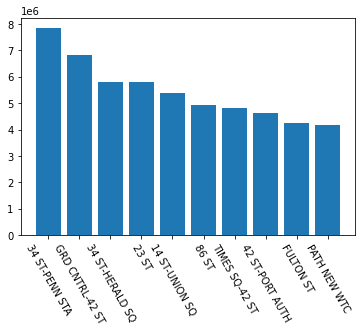

In [27]:
# plotting top 10 stations by daily activity
import matplotlib.pyplot as plt
%matplotlib inline

plt.bar('STATION','REAL_ACTIVITY',data=daily_top10);
plt.xticks(rotation=300);

# Working with hourly data

In [129]:
# creating objects for each station to plot
mask = (mta_df['STATION'] == '34 ST-PENN STA')
penn = mta_df[mask]

mask = (mta_df['STATION'] == 'GRD CNTRL-42 ST')
cntr = mta_df[mask]

mask = (mta_df['STATION'] == '34 ST-HERALD SQ')
herald = mta_df[mask]

In [130]:
# ATTEMPTING TO BIN INTO HOURS
penn['HOUR'] = penn['DATE_TIME'].apply(lambda x: x.hour)
cntr['HOUR'] = cntr['DATE_TIME'].apply(lambda x: x.hour)
herald['HOUR'] = herald['DATE_TIME'].apply(lambda x: x.hour)

<ipython-input-130-9f3076bd3f86>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  penn['HOUR'] = penn['DATE_TIME'].apply(lambda x: x.hour)
<ipython-input-130-9f3076bd3f86>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cntr['HOUR'] = cntr['DATE_TIME'].apply(lambda x: x.hour)
<ipython-input-130-9f3076bd3f86>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pan

In [212]:
penn_hr = penn.groupby('HOUR')['REAL_ACTIVITY'].sum()#.reset_index()
cntr_hr = cntr.groupby('HOUR')['REAL_ACTIVITY'].sum()#.reset_index()
herald_hr = herald.groupby('HOUR')['REAL_ACTIVITY'].sum()#.reset_index()
penn_hr

HOUR
0       85597.0
2       36364.0
4      585291.0
6      349129.0
7        2109.0
8     1217012.0
9       18223.0
10     414631.0
11       1701.0
12    1122841.0
14     686271.0
16    1839211.0
18     453279.0
20     559787.0
22     118859.0
Name: REAL_ACTIVITY, dtype: float64

Wait a minute, what is this really saying? This is the sum of all traffic for the whole dataset. There's no way that there are over a million people passing through penn station at 4pm each day. I need to divide these numbers by the number of days in the whole dataset!

In [200]:
# finding the number of days in the whole dataset
len(mta_df.DATE.unique())

28

In [203]:
type(penn_hr)

pandas.core.series.Series

In [211]:
# new column showing avg daily activity during that hour, and clarification of sum activity
penn_hr = penn_hr / 28
cntr_hr = cntr_hr / 28
herald_hr = herald_hr 

HOUR
0      109.179847
2       46.382653
4      746.544643
6      445.317602
7        2.690051
8     1552.311224
9       23.243622
10     528.866071
11       2.169643
12    1432.195153
14     875.345663
16    2345.932398
18     578.161990
20     714.014031
22     151.605867
Name: SUM_ACTIVITY, dtype: float64

# Now I will plot the three top stations by hour

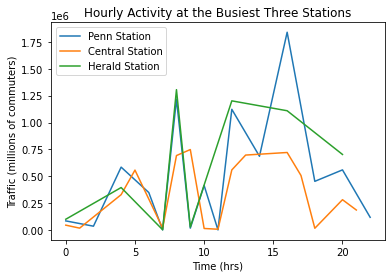

<Figure size 7200x7200 with 0 Axes>

In [191]:
plt.plot(penn_hr,label='Penn Station');
plt.plot(cntr_hr,label='Central Station');
plt.plot(herald_hr,label='Herald Station');
plt.title('Hourly Activity at the Busiest Three Stations');
plt.xlabel('Time (hrs)');
plt.ylabel('Traffic (millions of commuters)')

plt.legend()
plt.figure(figsize=(100,100))
plt.savefig(fname='hourly_top3',format='svg')

## Station-by-Station Analysis

Text(0.5, 1.0, 'Traffic through Penn Station per Hour')

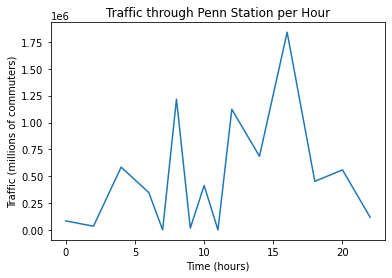

In [195]:
# analysis of Penn station by hour
plt.plot(penn_hr);
plt.xlabel('Time (hours)')
plt.ylabel('Traffic (millions of commuters)')
plt.title('Traffic through Penn Station per Hour')